/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Decoding: 100%|██████████| 16384/16384 [00:00<00:00, 19934.86it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Decoding: 100%|██████████| 16384/16384 [00:00<00:00, 20615.61it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Decoding: 100%|██████████| 16384/16384 [00:00<00:00, 18904.70it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default v

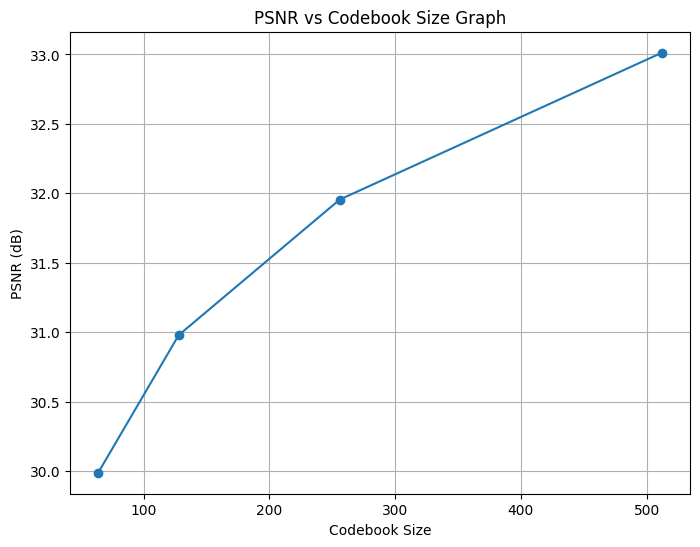

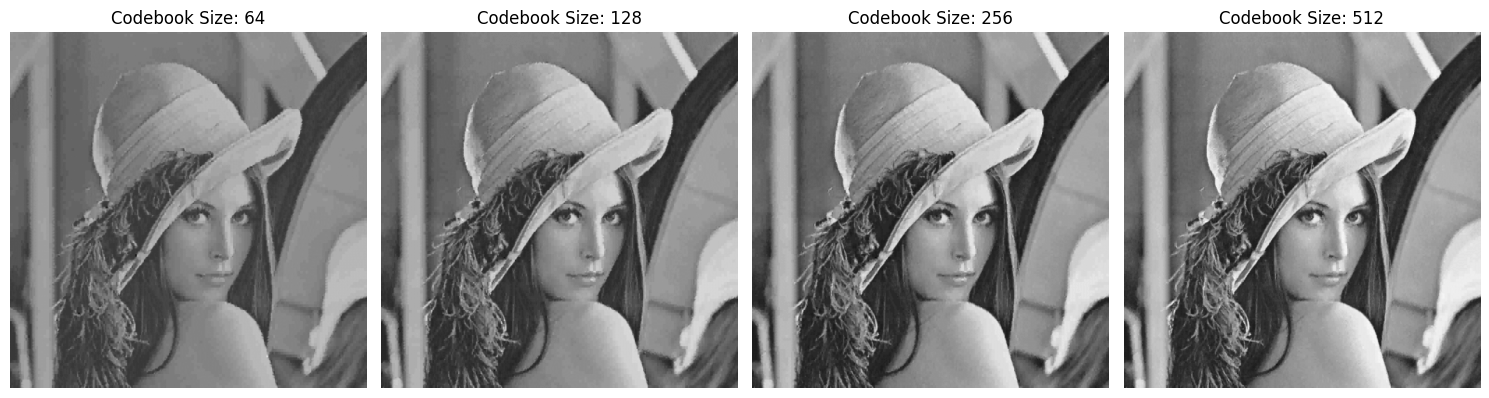

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Decoding: 100%|██████████| 16384/16384 [00:00<00:00, 24536.02it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Decoding: 100%|██████████| 16384/16384 [00:00<00:00, 24146.48it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Decoding: 100%|██████████| 16384/16384 [00:00<00:00, 26401.78it/s]


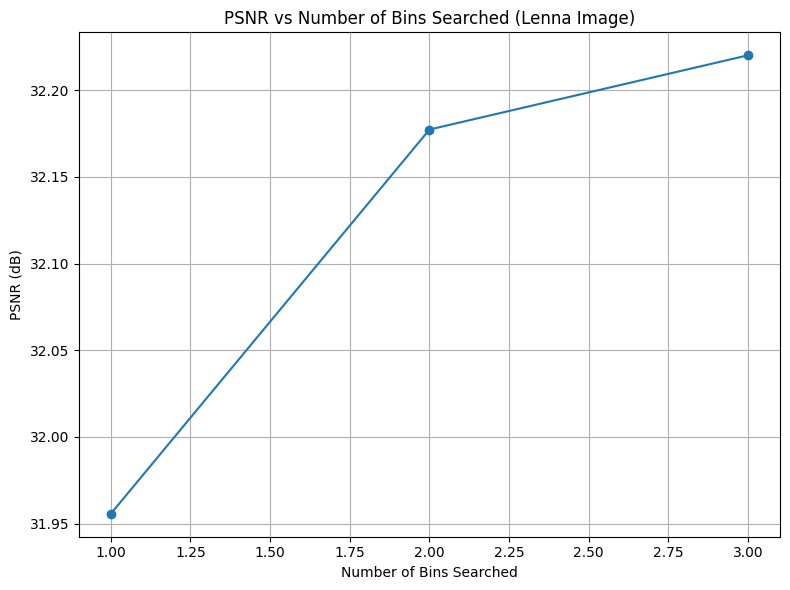

In [2]:
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

def fractal_encode(image, block_size, codebook_size, num_bins):
    # Divide the image into blocks
    blocks = []
    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            block = image[i:i+block_size, j:j+block_size]
            blocks.append(block.flatten())

    # Create a codebook using K-Means clustering
    kmeans = KMeans(n_clusters=codebook_size)
    kmeans.fit(blocks)
    codebook = kmeans.cluster_centers_

    # Classify each block into an archetype
    archetypes = kmeans.predict(blocks)

    # Compute the fractal parameters for each block
    fractal_params = []
    for i in tqdm(range(len(blocks)), desc="Encoding"):
        block = blocks[i]
        archetype = archetypes[i]
        error = np.inf
        best_params = None
        for j in range(-num_bins, num_bins + 1):
            for k in range(-num_bins, num_bins + 1):
                for l in range(-num_bins, num_bins + 1):
                    for m in range(-num_bins, num_bins + 1):
                        params = (j, k, l, m, archetype)
                        reconstructed_block = reconstruct_block(codebook, params, block_size)
                        curr_error = np.sum((block - reconstructed_block) ** 2)
                        if curr_error < error:
                            error = curr_error
                            best_params = params
        fractal_params.append(best_params)

    return fractal_params, codebook

def reconstruct_block(codebook, params, block_size):
    j, k, l, m, archetype = params
    block = codebook[archetype].reshape((block_size, block_size))
    block = j * block + k * np.fliplr(block) + l * np.flipud(block) + m * np.rot90(block, 2)
    return block.flatten()

def fractal_decode(fractal_params, codebook, block_size, num_iterations):
    image_size = int(np.sqrt(len(fractal_params))) * block_size
    image = np.zeros((image_size, image_size))
    for _ in range(num_iterations):
        for i in tqdm(range(len(fractal_params)), desc="Decoding"):
            j, k, l, m, archetype = fractal_params[i]
            block = codebook[archetype].reshape((block_size, block_size))
            block = j * block + k * np.fliplr(block) + l * np.flipud(block) + m * np.rot90(block, 2)
            x = (i // (image_size // block_size)) * block_size
            y = (i % (image_size // block_size)) * block_size
            image[x:x+block_size, y:y+block_size] = block
    return image

# Example usage
image = np.array(Image.open('lenna.bmp').convert('L'))
block_size = 4
codebook_sizes = [64, 128, 256, 512]
num_iterations = 10

psnr_values = []
num_bins_list = [1, 2, 3]

fig, ax = plt.subplots(figsize=(8, 6))

# Create a new figure for displaying images
fig_images, axs_images = plt.subplots(1, len(codebook_sizes), figsize=(15, 6))

for idx, codebook_size in enumerate(codebook_sizes):
    fractal_params, codebook = fractal_encode(image, block_size, codebook_size, num_bins=1)
    reconstructed_image = fractal_decode(fractal_params, codebook, block_size, num_iterations)

    # Calculate PSNR
    mse = np.mean((image - reconstructed_image) ** 2)
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    psnr_values.append(psnr)

    # Display the compressed image
    axs_images[idx].imshow(reconstructed_image, cmap='gray')
    axs_images[idx].set_title(f"Codebook Size: {codebook_size}")
    axs_images[idx].axis('off')

# Plot the PSNR vs codebook size graph
ax.plot(codebook_sizes, psnr_values, marker='o')
ax.set_xlabel('Codebook Size')
ax.set_ylabel('PSNR (dB)')
ax.set_title('PSNR vs Codebook Size Graph')
ax.grid()

plt.tight_layout()
plt.show()

# PSNR vs Number of Bins for Lenna Image
lenna_image = np.array(Image.open('lenna.bmp').convert('L'))
codebook_size = 256  # Choosing a fixed codebook size
psnr_values_bins = []

fig_bins, ax_bins = plt.subplots(figsize=(8, 6))

for num_bins in num_bins_list:
    fractal_params, codebook = fractal_encode(lenna_image, block_size, codebook_size, num_bins)
    reconstructed_image = fractal_decode(fractal_params, codebook, block_size, num_iterations)

    # Calculate PSNR
    mse = np.mean((lenna_image - reconstructed_image) ** 2)
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    psnr_values_bins.append(psnr)

# Plot the PSNR vs number of bins graph
ax_bins.plot(num_bins_list, psnr_values_bins, marker='o')
ax_bins.set_xlabel('Number of Bins Searched')
ax_bins.set_ylabel('PSNR (dB)')
ax_bins.set_title('PSNR vs Number of Bins Searched (Lenna Image)')
ax_bins.grid()

plt.tight_layout()
plt.show()
